# Imports and paths

In [1]:
import xarray as xr
import netCDF4 as ncdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import scipy.stats as ss
import scipy.interpolate as si
from pathlib import Path
rng = np.random.default_rng(42)

In [2]:
%cd ..

/home/cdauvill/tc_probabilistic_forecasting


In [3]:
with open("config.yml", 'r') as cfg_file:
    cfg = yaml.safe_load(cfg_file)
_TCIR_PATH_ = Path('/scratch/cdauvill/tcir/preprocessed_small')

# Loading

In [4]:
tcir_info = pd.read_csv(_TCIR_PATH_ / "train/info.csv", index_col=0)
tcir_info.head()

,BASIN,SID,LON,LAT,ISO_TIME,INTENSITY,R35_4qAVG,MSLP,HOUR_SIN,HOUR_COS,...,MONTH_SIN_-1,MONTH_SIN_0,MONTH_SIN_1,MONTH_SIN_2,MONTH_SIN_3,MONTH_SIN_4,RI_1,RI_2,RI_3,RI_4
3,ATLN,200523L,-1.496802,1.444350,2005-10-09 00:00:00,-1.012316,-1.06657,1.061709,0.002487,1.397654,...,-1.108026,-1.104436,-1.100861,-1.097301,-1.095667,-1.094852,0,0,0,0
4,ATLN,200523L,-1.511578,1.444350,2005-10-09 06:00:00,-1.012316,-1.06657,1.061709,1.422315,-0.009860,...,-1.108026,-1.104436,-1.100861,-1.097301,-1.095667,-1.094852,0,0,0,0
5,ATLN,200523L,-1.525217,1.455712,2005-10-09 12:00:00,-1.012316,-1.06657,1.061709,0.002487,-1.417374,...,-1.108026,-1.104436,-1.100861,-1.097301,-1.095667,-1.094852,0,0,0,0
6,ATLN,200523L,-1.533174,1.484117,2005-10-09 18:00:00,-1.012316,-1.06657,1.061709,-1.417342,-0.009860,...,-1.108026,-1.104436,-1.100861,-1.097301,-1.095667,-1.094852,0,0,0,0
7,ATLN,200523L,-1.542267,1.523885,2005-10-10 00:00:00,-1.012316,-1.06657,1.061709,0.002487,1.397654,...,-1.108026,-1.104436,-1.100861,-1.097301,-1.095667,-1.094852,0,0,0,0


In [5]:
info_mean = pd.read_csv(_TCIR_PATH_ / "info_mean.csv", header=None, index_col=0).squeeze("columns")
info_std = pd.read_csv(_TCIR_PATH_ / "info_std.csv", header=None, index_col=0).squeeze("columns")
tcir_info = tcir_info * info_std + info_mean

In [6]:
tcir_info['INTENSITY']

3       25.0
4       25.0
5       25.0
6       25.0
7       25.0
        ... 
1532    85.0
1533    75.0
1534    70.0
1535    65.0
1536    60.0
Name: INTENSITY, Length: 1142, dtype: float64

# Intensity distribution

## General distribution
Let's first look at the distribution of the intensity overall:

<Axes: xlabel='INTENSITY', ylabel='Count'>

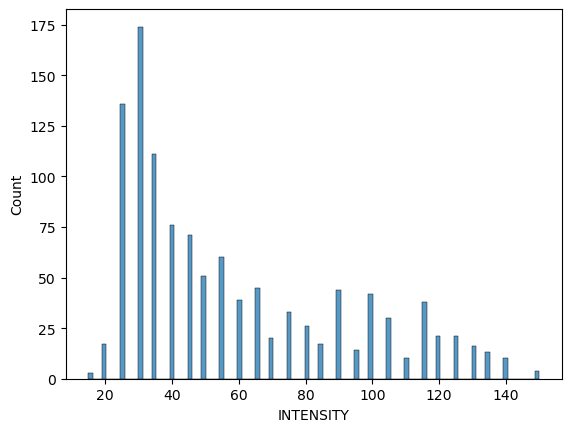

In [7]:
sns.histplot(tcir_info, x='INTENSITY', bins=100)

## Fitting distributions

In [8]:
def test_distrib(dist_names, dist_classes, samples):
    """
    Fits distributions from a set of given classes to the intensity samples.
    Performs KS tests to evaluate the fits, and plots the pdf & cdf.
    """
    ecdf = ss.ecdf(samples)
    fig, axes = plt.subplots(nrows=2, ncols=len(dist_names), squeeze=False,
                            tight_layout=True, figsize=(3*len(dist_names), 6))
    for k, (dist_name, dist_class) in enumerate(zip(dist_names, dist_classes)):
        params = dist_class.fit(samples)
        # KS test
        ksres = ss.kstest(samples, dist_name, params)
        print("KS p-value: ", ksres.pvalue)
    
        # Plot the PDF versus the data histogram
        x = np.linspace(0, 190, 100)
        axes[0, k].plot(x, dist_class.pdf(x, *params))
        axes[0, k].hist(samples, density=True, bins=20)

        # Plot the CDF versus the eCDF
        axes[1, k].plot(x, dist_class.cdf(x, *params))
        ecdf.cdf.plot(axes[1, k])

        axes[1, k].set_title(f'{dist_name} - p={ksres.pvalue:.2E}')
    plt.show()

KS p-value:  1.195571342265868e-15
KS p-value:  1.137416535165762e-12
KS p-value:  5.1837360302452285e-15
KS p-value:  3.558493998527744e-23
KS p-value:  4.44745037217285e-13


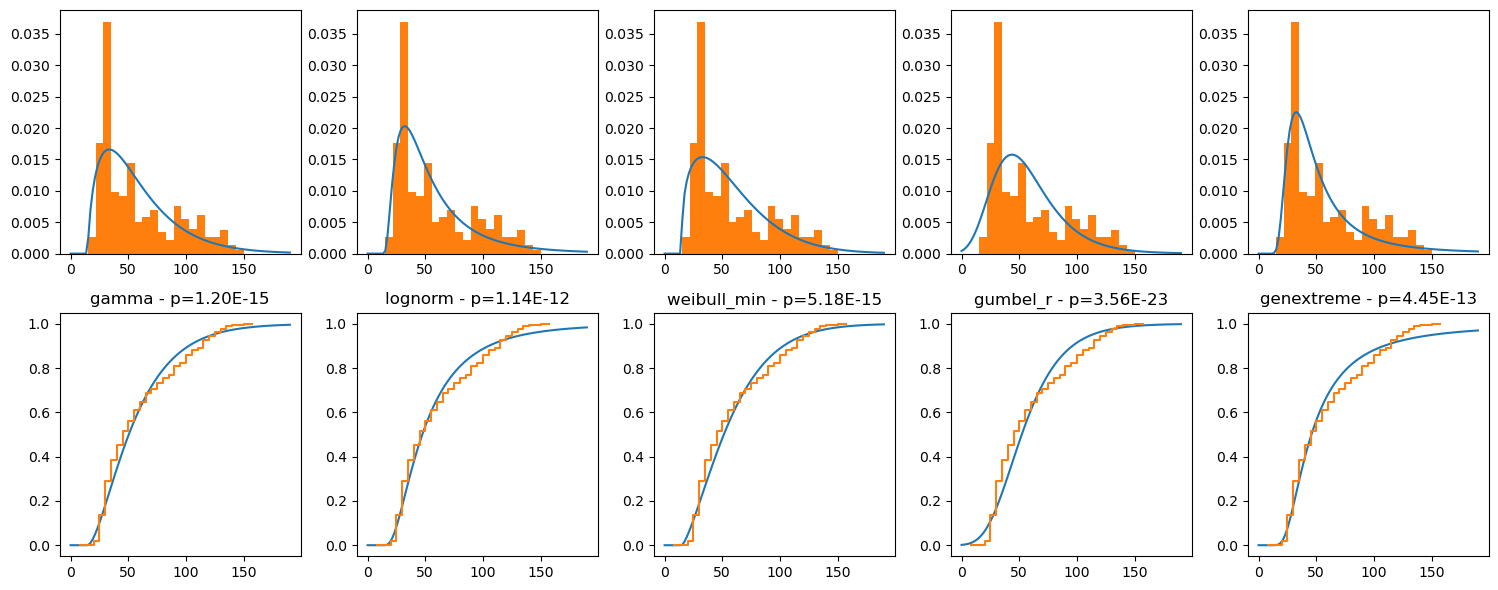

In [9]:
dist_names = ['gamma', 'lognorm', 'weibull_min', 'gumbel_r', 'genextreme']
dist_classes = [ss.gamma, ss.lognorm, ss.weibull_min, ss.gumbel_r, ss.genextreme]
test_distrib(dist_names, dist_classes, tcir_info['INTENSITY'])

The Kolmogorov-Smirnov statistic is based on the maximum distance between the empirical CDF and the the CDF of the tested distribution. Since our empirical distribution is actually discrete, its CDF makes big jumps. This means the distance between the empirical CDF and the fitted distribution is large just before each jump, flawing the KS statistic.

<Axes: xlabel='INTENSITY'>

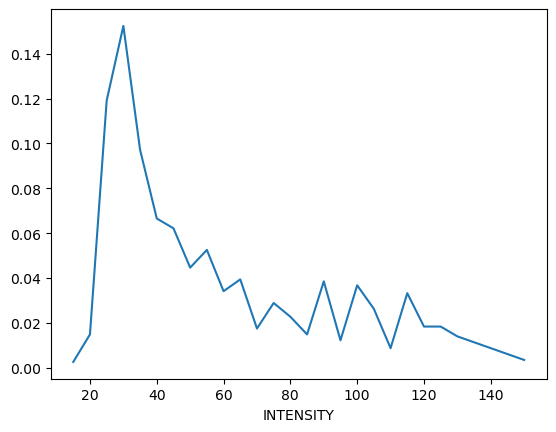

In [10]:
epdf = tcir_info['INTENSITY'].value_counts().sort_index()
epdf = epdf / epdf.sum()
epdf.plot()

### Adding noise to the discrete values
Since the recorded intensities in IBTrACS are actually discrete, we'll add noise to turn them into a continous distribution (which is of course the case for the real intensities). We'll use gaussian noise centered on the recorded values. Since the uncertainty estimates in IBTrACS is +/- 10kts for storms after 2000, we'll use a standard deviation of 5kts, which is absolutely arbitrary but somewhat respects the little information we have from IBTrACS.

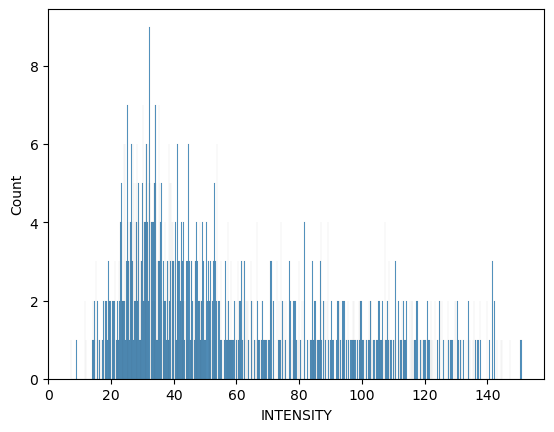

In [11]:
noised_ws = tcir_info['INTENSITY'] + rng.normal(0, 5, tcir_info['INTENSITY'].shape)
sns.histplot(x=noised_ws, bins=1000)
plt.show()

KS p-value:  5.905815702609886e-06
KS p-value:  0.00013470951029741684
KS p-value:  0.0
KS p-value:  1.573065824974348e-05
KS p-value:  7.1406820507671e-05


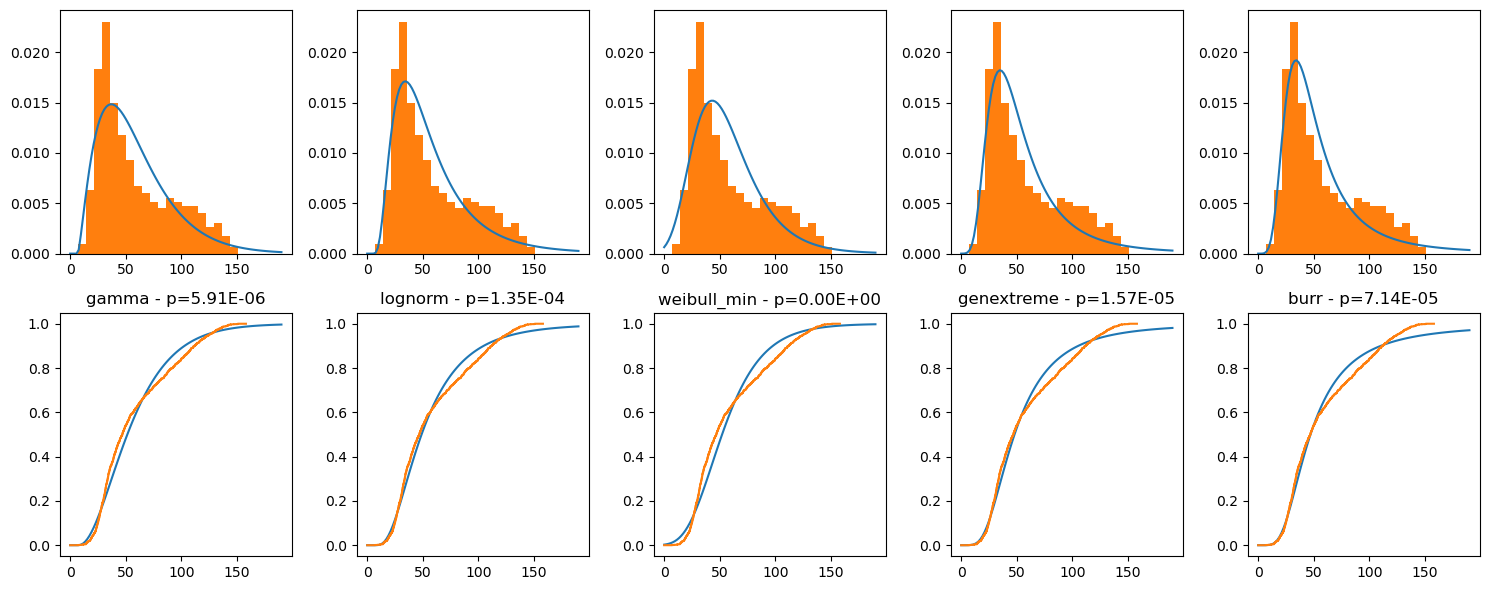

In [12]:
dist_names = ['gamma', 'lognorm', 'weibull_min', 'genextreme', 'burr']
dist_classes = [ss.gamma, ss.lognorm, ss.gumbel_r, ss.genextreme, ss.burr]
test_distrib(dist_names, dist_classes, noised_ws)

In [13]:
for dist_name in ['gumbel_r', 'weibull_min']:
    res = ss.anderson(noised_ws, dist_name)
    print(f'{dist_name} : ')
    print(res, '\n')

gumbel_r : 
AndersonResult(statistic=23.31906781201974, critical_values=array([0.471, 0.633, 0.753, 0.872, 1.032]), significance_level=array([25. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=43.21293842007235, scale=24.218703617482912)
 success: True
 message: '`anderson` successfully fit the distribution to the data.') 

weibull_min : 
AndersonResult(statistic=15.83410990713719, critical_values=array([0.342, 0.472, 0.563, 0.636, 0.758, 0.88 , 1.043, 1.168]), significance_level=array([0.5  , 0.75 , 0.85 , 0.9  , 0.95 , 0.975, 0.99 , 0.995]), fit_result=  params: FitParams(c=1.6167067316544792, loc=7.082154350470012, scale=57.52828108512704)
 success: True
 message: '`anderson` successfully fit the distribution to the data.') 



## Temporal conditional distributions

Let's now look at the distribution of the *next* intensity, i.e. $P(Y_t|Y_{t-1})$:

In [14]:
tcir_info['NEXT_INTENSITY'] = tcir_info.groupby('SID')['INTENSITY'].shift(-1)
tcir_info['DELTA_INTENSITY'] = (tcir_info['NEXT_INTENSITY'] - tcir_info['INTENSITY'])
tcir_info.head(10)

/tmp/ipykernel_8169/3660393482.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tcir_info['NEXT_INTENSITY'] = tcir_info.groupby('SID')['INTENSITY'].shift(-1)
/tmp/ipykernel_8169/3660393482.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tcir_info['DELTA_INTENSITY'] = (tcir_info['NEXT_INTENSITY'] - tcir_info['INTENSITY'])


,BASIN,DELTA_INTENSITY_-1,DELTA_INTENSITY_-2,DELTA_INTENSITY_-3,DELTA_INTENSITY_0,DELTA_INTENSITY_1,DELTA_INTENSITY_2,DELTA_INTENSITY_3,DELTA_INTENSITY_4,DELTA_LAT_-1,...,SSHS_-1,SSHS_-2,SSHS_-3,SSHS_0,SSHS_1,SSHS_2,SSHS_3,SSHS_4,NEXT_INTENSITY,DELTA_INTENSITY
3,NaN,5.000000e+00,5.000000e+00,5.000000e+00,NaN,4.440892e-16,3.330669e-16,5.551115e-16,4.163336e-16,-5.000000e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,-2.220446e-16,5.000000e+00,5.000000e+00,NaN,4.440892e-16,3.330669e-16,5.551115e-16,4.163336e-16,-2.775558e-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,-2.220446e-16,-8.881784e-16,5.000000e+00,NaN,4.440892e-16,3.330669e-16,5.551115e-16,5.000000e+00,-2.000000e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,-2.220446e-16,-8.881784e-16,-4.440892e-16,NaN,4.440892e-16,3.330669e-16,5.000000e+00,5.000000e+00,-5.000000e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,-2.220446e-16,-8.881784e-16,-4.440892e-16,NaN,4.440892e-16,5.000000e+00,5.000000e+00,5.000000e+00,-7.000000e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,-2.220446e-16,-8.881784e-16,-4.440892e-16,NaN,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,-9.000000e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,-5.000000e+00,-5.000000e+00,-5.000000e+00,NaN,4.440892e-16,3.330669e-16,5.551115e-16,4.163336e-16,-9.000000e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,-2.220446e-16,-5.000000e+00,-5.000000e+00,NaN,4.440892e-16,3.330669e-16,5.551115e-16,4.163336e-16,-1.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,-2.220446e-16,-8.881784e-16,-5.000000e+00,NaN,4.440892e-16,3.330669e-16,5.551115e-16,4.163336e-16,-8.000000e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,-2.220446e-16,-8.881784e-16,-4.440892e-16,NaN,4.440892e-16,3.330669e-16,5.551115e-16,4.163336e-16,-1.200000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='DELTA_INTENSITY', ylabel='Count'>

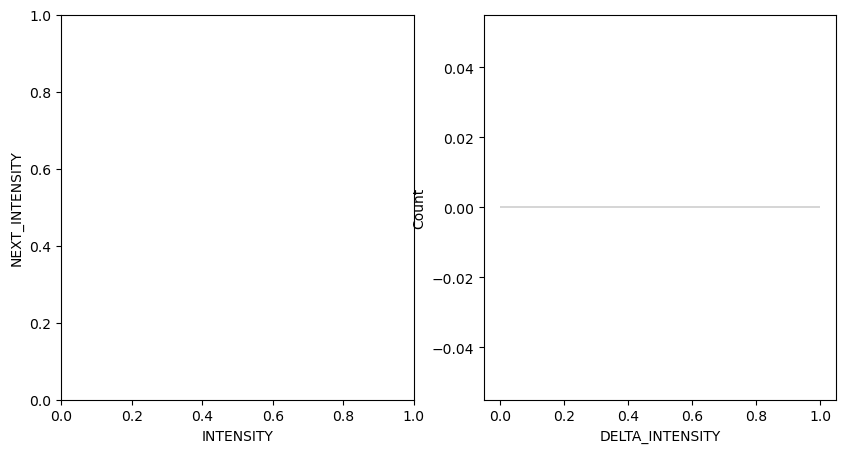

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.histplot(tcir_info, x='INTENSITY', y='NEXT_INTENSITY', ax=axes[0])
sns.histplot(tcir_info, x='DELTA_INTENSITY', ax=axes[1], bins=100)

Let's statistically test for normality:

In [16]:
ntest_res = ss.normaltest(tcir_info['DELTA_INTENSITY'].dropna().values)
ntest_res

/home/cdauvill/mambaforge/envs/tc/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1171: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/home/cdauvill/mambaforge/envs/tc/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/cdauvill/mambaforge/envs/tc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cdauvill/mambaforge/envs/tc/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: skewtest is not valid with less than 8 samples; 0 samples were given.

Hence we can reject the hypothesis that $P(Y_{t+1}|Y_t)$ is a normal distribution.

One could wonder: is the evolution of the intensity over more than two timesteps a multivariate gaussian ?

In [ ]:
vmax_evol_df = tcir_info[['SID', 'ISO_TIME', 'INTENSITY']].copy()
for i in range(1, 9):
    vmax_evol_df[f'INTENSITY_+{i}'] = vmax_evol_df.groupby('SID')['INTENSITY'].shift(-i)
    vmax_evol_df[f'DELTA_INTENSITY_+{i}'] = vmax_evol_df[f'INTENSITY_+{i}'] - vmax_evol_df['INTENSITY']
vmax_evol_df = vmax_evol_df.dropna(axis='rows')

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 10), tight_layout=True)
for i, ax in enumerate(axes.flatten()):
    sns.histplot(vmax_evol_df, x=f'DELTA_INTENSITY_+{i+1}', ax=ax, bins=30)

# ERA5 Intensity vs TCIR Intensity

Load the full datacube in lazy mode:

In [8]:
datacube = xr.open_dataset(_TCIR_PATH_ / "train/datacube.nc")
datacube

<xarray.Dataset> Size: 2GB
Dimensions:         (h_pixel_offset: 201, v_pixel_offset: 201, sid_time: 1541)
Coordinates:
  * h_pixel_offset  (h_pixel_offset) int64 2kB -100 -99 -98 -97 ... 97 98 99 100
  * v_pixel_offset  (v_pixel_offset) int64 2kB -100 -99 -98 -97 ... 97 98 99 100
    sid             (sid_time) <U7 43kB ...
    time            (sid_time) datetime64[ns] 12kB ...
Dimensions without coordinates: sid_time
Data variables:
    IR              (sid_time, v_pixel_offset, h_pixel_offset) float32 249MB ...
    PMW             (sid_time, v_pixel_offset, h_pixel_offset) float32 249MB ...
    u10             (sid_time, v_pixel_offset, h_pixel_offset) float64 498MB ...
    v10             (sid_time, v_pixel_offset, h_pixel_offset) float64 498MB ...
    msl             (sid_time, v_pixel_offset, h_pixel_offset) float64 498MB ...
    t2m             (sid_time, v_pixel_offset, h_pixel_offset) float64 498MB ...

Load the normalization constants:

In [9]:
datacube_mean = xr.open_dataset(_TCIR_PATH_ / "datacube_mean.nc")
datacube_std = xr.open_dataset(_TCIR_PATH_ / "datacube_std.nc")

Let's load the $u$ and $v$ wind fields, denormalize them, and deduce the wind speed field:

In [10]:
datacube.isnull().sum()

<xarray.Dataset> Size: 48B
Dimensions:  ()
Data variables:
    IR       int64 8B 0
    PMW      int64 8B 0
    u10      int64 8B 0
    v10      int64 8B 0
    msl      int64 8B 0
    t2m      int64 8B 0

In [11]:
u, v = datacube['u10'], datacube['v10']
u = u * datacube_std['u10'] + datacube_mean['v10']
v = v * datacube_std['v10'] + datacube_mean['v10']
ws = np.sqrt(u ** 2 + v ** 2)
ws

<xarray.DataArray (sid_time: 1541, v_pixel_offset: 201, h_pixel_offset: 201)> Size: 498MB
array([[[ 7.93363662,  7.94214159,  7.92953789, ...,  6.01221221,
          5.96211617,  5.91218954],
        [ 7.93745402,  7.94865749,  7.93749225, ...,  6.0743646 ,
          6.01613294,  5.9581226 ],
        [ 7.95128968,  7.96388304,  7.95217021, ...,  6.13725746,
          6.08226572,  6.02750476],
        ...,
        [ 1.36967057,  1.29522071,  1.23643632, ...,  5.85569016,
          5.89935882,  5.94303583],
        [ 1.28640928,  1.21326147,  1.17650051, ...,  5.79824542,
          5.84820958,  5.89818368],
        [ 1.20615348,  1.1353474 ,  1.12165771, ...,  5.74161295,
          5.79789391,  5.85418608]],

       [[ 7.98419689,  7.96286059,  7.88294761, ...,  6.03373462,
          6.06229058,  6.09099276],
        [ 7.97402133,  7.9514    ,  7.86298437, ...,  5.99902326,
          6.02466386,  6.05045519],
        [ 7.94046973,  7.90974616,  7.81898869, ...,  5.97381142,
          5.99272928,  6.01172941],
...
        [ 7.50676587,  7.60386575,  7.69224556, ..., 11.34187706,
         11.28127164, 11.22071243],
        [ 7.43548546,  7.52918174,  7.61620799, ..., 11.23926745,
         11.17803019, 11.11685487],
        [ 7.3642365 ,  7.45454207,  7.5402202 , ..., 11.13666648,
         11.0747921 , 11.01299781]],

       [[ 6.58348559,  6.60520434,  6.618493  , ...,  6.5949687 ,
          6.49261347,  6.39028093],
        [ 6.69113142,  6.71467884,  6.72930088, ...,  6.76886331,
          6.67209435,  6.57539019],
        [ 6.76042528,  6.78470902,  6.80297825, ...,  6.84902946,
          6.76323359,  6.67746773],
        ...,
        [11.27819724, 11.39762613, 11.51059337, ..., 11.94642676,
         11.85354759, 11.7611004 ],
        [11.25277064, 11.37110323, 11.47659793, ..., 11.91382094,
         11.81760217, 11.72185344],
        [11.22805066, 11.34517746, 11.44313611, ..., 11.88122501,
         11.78167316, 11.68263124]]])
Coordinates:
  * h_pixel_offset  (h_pixel_offset) int64 2kB -100 -99 -98 -97 ... 97 98 99 100
  * v_pixel_offset  (v_pixel_offset) int64 2kB -100 -99 -98 -97 ... 97 98 99 100
    sid             (sid_time) <U7 43kB '200523L' '200523L' ... '201717W'
    time            (sid_time) datetime64[ns] 12kB 2005-10-08T06:00:00 ... 20...
Dimensions without coordinates: sid_time

In [12]:
datacube.isnull().mean().compute()

<xarray.Dataset> Size: 48B
Dimensions:  ()
Data variables:
    IR       float64 8B 0.0
    PMW      float64 8B 0.0
    u10      float64 8B 0.0
    v10      float64 8B 0.0
    msl      float64 8B 0.0
    t2m      float64 8B 0.0

Deduce the maximum wind speed of each sample, according to the ERA5 patches:

In [13]:
max_era5_ws = ws.max(dim=['h_pixel_offset', 'v_pixel_offset'])

Convert the ERA5 wind speeds to knots (from m/s):

In [14]:
max_era5_ws *= 1.94384

Select only the entries that are also in the best-track data:

In [15]:
max_era5_ws = max_era5_ws.isel(sid_time=tcir_info.index)

Let's plot the ERA5 max wind speed versus the best-track WS:

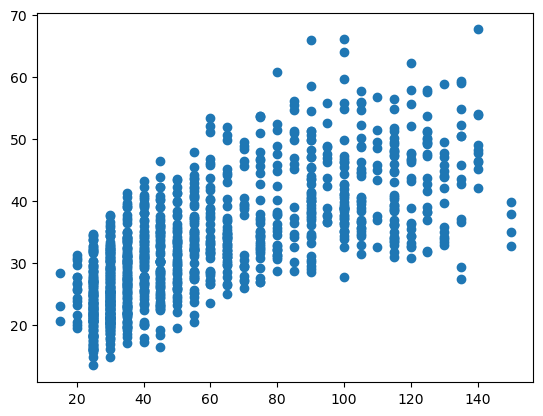

In [16]:
plt.scatter(tcir_info['INTENSITY'], max_era5_ws)

Let's do the same for the MSLP:

In [17]:
mslp = datacube['msl']
mslp = mslp * datacube_std['msl'] + datacube_mean['msl']

In [18]:
mslp_era5 = mslp.min(dim=['h_pixel_offset', 'v_pixel_offset'])
mslp_era5 = mslp_era5.isel(sid_time=tcir_info.index)

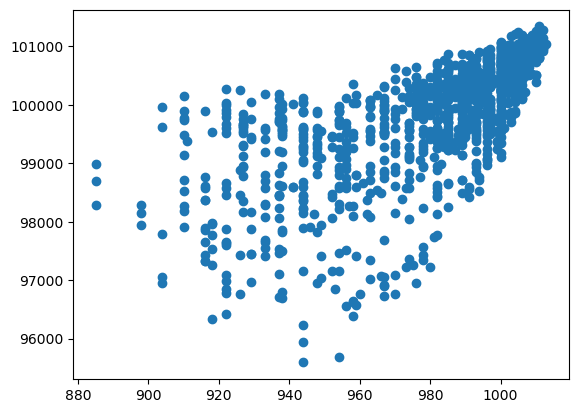

In [19]:
plt.scatter(tcir_info['MSLP'], mslp_era5)